In [1]:
import tensorflow as tf 
import tensorflow_addons as tfa
from skimage.transform import warp, AffineTransform
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import math
import seaborn as sns
tf.random.set_seed(42)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


from tensorflow.keras.applications.densenet import DenseNet121,DenseNet169, DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam





@tf.function
def apply_random_scaling(image, minval=-.02, maxval=.02):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    source_size = image.shape
    target_size = tf.cast(source_size[0]*(1.0+param), tf.int32), tf.cast(source_size[1]*(1.0+param), tf.int32)
    output = tf.image.resize_with_crop_or_pad(tf.image.resize(image, target_size), source_size[0], source_size[1])
    return output, param

def apply_random_shearing(image, minval=-5., maxval=5.):
    #param = tf.random.uniform([], minval=tf.math.atan(minval/image.shape[1]), maxval=tf.math.atan(maxval/image.shape[1]))
    #param = tf.random.uniform([], minval=tf.math.atan(), maxval=tf.math.atan(maxval/image.shape[1]))
    param = np.random.uniform(low=minval, high=maxval)
    output = warp(np.array(image), AffineTransform(shear=np.arctan(param/image.shape[1])).inverse)
    return output, param
@tf.function
def apply_random_rotation(image, minval=-7, maxval=7):
    param = tf.random.uniform([], minval=minval, maxval=maxval)
    output = tfa.image.rotate(image, param*math.pi/180.0, interpolation='BILINEAR')
    return output, param


def apply_test_time_augmentation(image, labels, image_id):
    '''Implements TTA, https://arxiv.org/pdf/1911.06475.pdf pag13:
    
    (...) for each test CXR, we applied a random 
    transformation (amongst horizontal flipping, 
    rotating ±7 degrees, scaling±2%,and shearing±5 pixels) 10 times (...)
    
    :param image - the input image
    :param labels - the labels associated with the image
    :param image_id - an ordinal or id associated with the image
    
    :returns - a DataFrame containing one row for each generated image (+1 for the original one), a list of generated images and labels. 
    The dataframe contains the augmentation method used, the parameter and the image/label filenames.
    '''
    dataframe = pd.DataFrame()
    image_list = list()
    image_list.append((image, labels))
    
    dataframe = dataframe.append({'image_id':image_id,
                                      'tta_id':0,
                                      'image_fn':'{}_{}_image.npy'.format(image_id, 0),
                                      'labels_fn':'{}_label.npy'.format(image_id),
                                      'method':'ORIGINAL',
                                      'param':0.0}, ignore_index=True)
    
    for i in range(1, 11):

        random_function = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)

        output = image
        param = tf.constant(0.0)        
        
        if tf.equal(random_function, 0):
            output = tf.image.flip_left_right(image)
            param = tf.constant(0.0)
            method = 'FLIP'
        if tf.equal(random_function, 1):
            output, param = apply_random_rotation(image)
            method = 'ROTATION'
        if tf.equal(random_function, 2):
            output, param = apply_random_scaling(image)
            method = 'SCALING'
        if tf.equal(random_function, 3):
            output, param = apply_random_shearing(image)
            method = 'SHEAR'
        image_list.append((output, labels))
        
        dataframe = dataframe.append({'image_id':image_id,
                                      'tta_id':int(i),
                                      'image_fn':'{}_{}_image.npy'.format(image_id, i),
                                      'labels_fn':'{}_label.npy'.format(image_id),
                                      'method':method,
                                      'param':float(param)}, ignore_index=True)
    return dataframe, image_list


def record_parser(example, image_size=224):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image.set_shape([image_size, image_size, 3])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename, image_size=224):
  base_path = 'datasets/'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parser = lambda x, size=image_size: record_parser(x, image_size=size)
  parsed_dataset = dataset.map(parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  return parsed_dataset

def make_tta_dataset(csv_path, test_dataset_path='test_set_cropped.tfrecords', image_size=224):
    '''
    TTA Dataset is built upon the test set. If the csv file exists in the given path, then this function use it to load the dataset.
    Otherwise first the test dataset is loaded and each image is saved in a different numpy file. 
    '''
    tta_images = list()
    tta_labels = list()
    folder = os.path.dirname(csv_path)
    
    if not os.path.isfile(csv_path):
        print("Dataset not found. Generating...")
        # Generate dataset
        # Load test dataset
        
        os.makedirs(folder, exist_ok=True)
        test_dataset = make_dataset(test_dataset_path).prefetch(1)
        # Apply augmentation
        tta_dataset = list()
        tta_csv = pd.DataFrame()
        for r, record in enumerate(test_dataset):
            aug_dataframe, aug_images = apply_test_time_augmentation(record[0], record[1], r)
            tta_csv = tta_csv.append(aug_dataframe, ignore_index=True)
            for (_, (image_fn, labels_fn)), (aug_image, aug_label) in zip(aug_dataframe[['image_fn', 'labels_fn']].iterrows(), aug_images):
                np.save(os.path.join(folder, image_fn), aug_image)
                if _ == 0:
                    np.save(os.path.join(folder, labels_fn), aug_label)
        tta_csv.to_csv(csv_path)
    
    print("Loading dataset "+ csv_path)
    # Load dataset
    csv = pd.read_csv(csv_path, index_col=0)
    for g, augmentation_group in csv.loc[csv['method'] != 'ORIGINAL'].groupby(['image_id']):
        current_aug = list()
        for _, (image_fn, labels_fn) in augmentation_group[['image_fn', 'labels_fn']].iterrows():
            current_aug.append(np.load(os.path.join(folder, image_fn)))
            label = np.load(os.path.join(folder, labels_fn))
        tta_images.append(np.stack(current_aug))
        tta_labels.append(label)
    return tf.data.Dataset.from_tensor_slices((tta_images, tta_labels))

batch_size = 64
#train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#train_dataset = make_dataset('training_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)

# UNCOMMENT TO ENABLE TRAINING
cond_train_dataset = make_dataset('conditional_training.tfrecords').shuffle(buffer_size=128).batch(batch_size).prefetch(1) # Dataset of only positive parents, used for pre-training
train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size).prefetch(1) # Full dataset, using for fine-tuning the network

val_dataset = make_dataset('validation_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
tta_dataset = make_tta_dataset('datasets/tta_dataset/tta.csv')

Loading dataset datasets/tta_dataset/tta.csv


In [2]:
basemodel = DenseNet121

# Label Definition

In [3]:
flattened_label_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

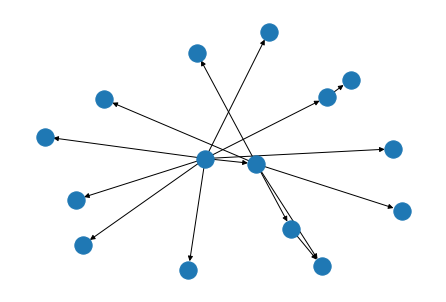

In [4]:
import networkx as nx
def build_label_graph():
    labels = nx.DiGraph()
    labels.add_node(0, name='No Finding', depth=1)
    labels.add_node(1, name='Enlarged Cardiomediastinum', depth=1)
    labels.add_node(2, name='Cardiomegaly', depth=2)
    labels.add_edge(1, 2)
    labels.add_node(3, name='Lung Opacity', depth=1)
    labels.add_node(4, name='Lung Lesion', depth=2)
    labels.add_edge(3, 4)
    labels.add_node(5, name='Edema', depth=2)
    labels.add_edge(3, 5)
    labels.add_node(6, name='Consolidation', depth=2)
    labels.add_edge(3, 6)
    labels.add_node(7, name='Pneumonia', depth=3)
    labels.add_edge(3, 7)
    labels.add_edge(6, 7)
    labels.add_node(8, name='Atelectasis', depth=2)
    labels.add_edge(3, 8)
    labels.add_node(9, name='Pneumothorax', depth=1)
    labels.add_node(10, name='Pleural Effusion', depth=1)
    labels.add_node(11, name='Pleural Other', depth=1)
    labels.add_node(12, name='Fracture', depth=1)
    labels.add_node(13, name='Support Devices', depth=1)

    # Adding root
    labels.add_node(-1, name='root')
    for node, attr in nx.nodes(labels).items():
        if node == -1:
            continue
        elif attr['depth']==1:
            labels.add_edge(-1, node)
    return labels

def build_ancestors(graph):
    # Finding all the paths from leaves to root
    ancestors_by_name = {}
    ancestors_by_id = {}
    for node, attr in nx.nodes(graph).items():
        if node == -1:
            continue
        ancestors_by_name[attr['name']] = []
        ancestors_by_id[node] = []
        for path_idx in nx.all_simple_paths(graph, -1, node):
            ancestors_by_name[attr['name']].append(list(reversed([nx.nodes(graph)[n]['name'] for n in path_idx if n != -1])))
            ancestors_by_id[node].append(list(reversed([n for n in path_idx if n != -1])))
    nx.draw(graph)
    return ancestors_by_id

labels = build_label_graph()
label_names = nx.get_node_attributes(labels,'name')
del label_names[-1]

ancestors_by_id = build_ancestors(labels)

# Losses Definition

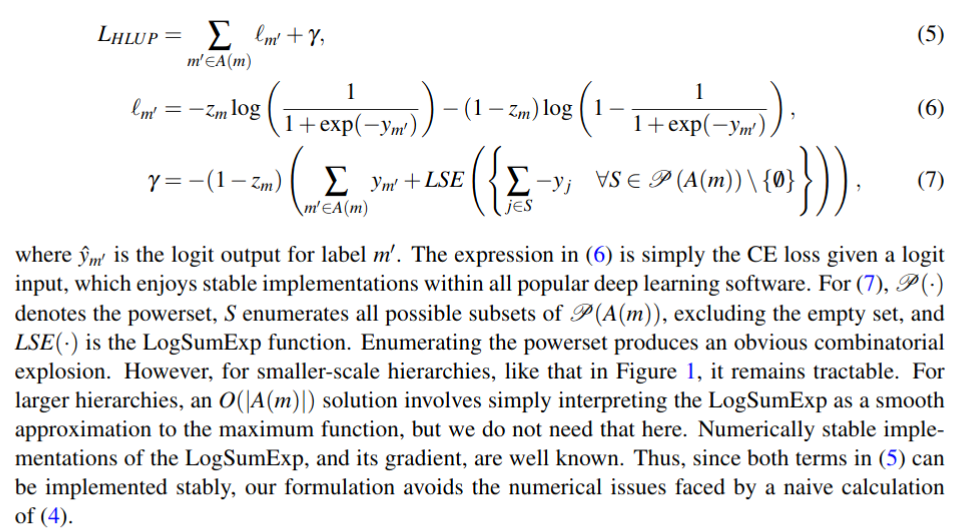

In [5]:
from itertools import chain, combinations
def get_powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    powerset = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    # Removing the null set
    return [list(s) for s in powerset if len(s)>0]

def build_gamma(y, z, m, ancestors):    
    LSE_PARAM = tf.stack([tf.reduce_sum(tf.stack([-y[:, j] for j in S], axis=-1), axis=-1) for S in get_powerset(ancestors)], axis=-1)
    LSE = tf.reduce_logsumexp(LSE_PARAM, axis=-1)
    gamma_factor = LSE
    for m_prime in ancestors:
        gamma_factor = gamma_factor + y[:, m_prime]
    gamma = -(1. - z[:, m])*(gamma_factor)
    return gamma

def get_loss_for_disease(y, z, m, ancestors):
    '''
    :param y - the LOGIT output of the network
    :param z - the ground truth
    '''
    crossentropy = tf.reduce_sum(tf.stack([tf.losses.BinaryCrossentropy(from_logits=True)(z[:,m], y[:, m_prime]) for m_prime in ancestors], axis=-1), axis=-1)
    gamma = build_gamma(y, z, m, ancestors)
    loss = crossentropy + gamma
    
    return tf.reduce_mean(loss, axis=0)

def build_unconditional_loss(y, z, ancestors_by_id, by_path=False):
    loss_function = []
    if by_path:
        # calculate the loss for each path. Alternative version is "A(m): Union of all the antecedents of p"
        for m in ancestors_by_id:
            for ancestor_path in ancestors_by_id[m]:
                loss_function.append(get_loss_for_disease(y, z, m, ancestor_path))
    else:
        for m, paths in ancestors_by_id.items():
            ancestors = set()
            for p in paths:
                ancestors.update(p)
            ancestors = list(ancestors)
            loss_function.append(get_loss_for_disease(y, z, m, ancestors))
    return tf.stack(loss_function, axis=-1)

def build_conditional_loss(y_sigmoid, z, labels):
    """ The conditional loss is simply a CrossEntropy since the dataset has been already processed with the indicator function"""
    loss = [tf.losses.BinaryCrossentropy(from_logits=False)(z[:,m], y_sigmoid[:, m]) for m in labels]
    return tf.stack(loss, axis=-1)

model_loss_conditional = lambda true, pred, labels=labels: build_conditional_loss(pred, true, labels) # Used for pre-training
model_loss_unconditional = lambda true, pred, ancestors=ancestors_by_id: build_unconditional_loss(pred, true, ancestors) # Used for finetuning

# Finetuning with conditional probabilities

In [6]:
def build_model(basemodel):
    base_model = basemodel(include_top=False,
                                 weights='imagenet',
                                 input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    logits = Dense(14)(x) 
    predictions = Activation('sigmoid')(logits)
    return Model(inputs=base_model.input, outputs=[predictions, logits])


def step_decay(epoch):
    initial_lr = 1e-4
    drop = 0.1
    return initial_lr * np.power(drop,epoch)

outputFolder = 'ModelsRetrained/{}/PreTraining_HLCP/'.format(basemodel.__name__)
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath_pretraining=outputFolder+"model-{epoch:02d}.hdf5"

tb_writer_t = tf.summary.create_file_writer(outputFolder + 'tensorboard_log/training/')
tb_writer_v = tf.summary.create_file_writer(outputFolder + 'tensorboard_log/validation/')


lr_scheduler = LearningRateScheduler(step_decay)
#early_stopping = EarlyStopping(monitor='val_AUC',mode='max',patience=4)
# checkpoint_cb = ModelCheckpoint(filepath,save_best_only = False,save_weights_only = False,
#                                save_freq='epoch',verbose=False)

opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
# callbacks = [lr_scheduler,checkpoint_cb,early_stopping]


model = build_model(basemodel)
# model.compile(loss=model_loss, optimizer=opt, metrics=['accuracy','AUC'])
checkpoint = tf.train.Checkpoint(model=model)

In [7]:
def train_step(x, gt, model, optimizer, pretraining):
        
    if pretraining:
        model_loss = model_loss_conditional
    else:
        model_loss = model_loss_unconditional
    with tf.GradientTape(persistent=True) as tape:
        predictions, logits = model([x], training=True)
        losses_by_disease = model_loss(gt, logits)
        total_loss = tf.reduce_mean(losses_by_disease, axis=0)
        
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return losses_by_disease, predictions

def valid_step(x, gt, model, pretraining):
    if pretraining:
        model_loss = model_loss_conditional
    else:
        model_loss = model_loss_unconditional
    predictions, logits = model([x], training=False)
    return model_loss(gt, logits), predictions
    
def epoch_end(train_loss_avg, train_auc_avg, valid_loss_avg, valid_auc_avg, epoch):
    """Writes results to tensorboard. Returns the current mean validation AUC for model selection"""
    with tb_writer_t.as_default():
        for m, labname in label_names.items():
            tf.summary.scalar("loss_"+labname, train_loss_avg[m].result(), step=epoch)
            tf.summary.scalar("auc_"+labname, train_auc_avg[m].result(), step=epoch)
        tf.summary.scalar("mean_loss", tf.reduce_mean([train_loss_avg[m].result() for m in label_names]), step=epoch)
        tf.summary.scalar("mean_auc", tf.reduce_mean([train_auc_avg[m].result() for m in label_names]), step=epoch)
        tf.summary.scalar("learning_rate", opt.lr, step=epoch)
        tb_writer_t.flush()
    with tb_writer_v.as_default():
        for m, labname in label_names.items():
            tf.summary.scalar("loss_"+labname, valid_loss_avg[m].result(), step=epoch)
            tf.summary.scalar("auc_"+labname, valid_auc_avg[m].result(), step=epoch)
        tf.summary.scalar("mean_loss", tf.reduce_mean([valid_loss_avg[m].result() for m in label_names]), step=epoch)
        mean_auc = tf.reduce_mean([valid_auc_avg[m].result() for m in label_names])
        tf.summary.scalar("mean_auc", mean_auc, step=epoch)
        tb_writer_v.flush()
    return mean_auc
    

# Pre-Training

In [8]:
best_auc = 0
best_epoch = 0
best_model_filepath = ""

for epoch in range(1, 10):
    print("Epoch {}".format(epoch))
    # Manually set the learning rate
    opt.lr.assign(step_decay(epoch))
    train_loss_avg = [tf.keras.metrics.Mean() for m in label_names]
    valid_loss_avg = [tf.keras.metrics.Mean() for m in label_names]
    train_auc_avg = [tf.keras.metrics.AUC() for m in label_names]
    valid_auc_avg = [tf.keras.metrics.AUC() for m in label_names]
    
    for i, (ct, gt) in enumerate(cond_train_dataset):
        train_loss, predictions = train_step(ct, gt, model, opt, pretraining=True)
        [train_loss_avg[m].update_state(train_loss.numpy()[m]) for m in label_names];
        [train_auc_avg[m].update_state(gt[:, m], predictions[:,m]) for m in label_names];
        
                
    for i, (ct, gt) in enumerate(val_dataset):
        valid_loss, predictions = valid_step(ct, gt, model, pretraining=True)
        [valid_loss_avg[m].update_state(valid_loss.numpy()[m]) for m in label_names];
        [valid_auc_avg[m].update_state(gt[:, m], predictions[:,m]) for m in label_names];
        
            
    current_auc = epoch_end(train_loss_avg, train_auc_avg, valid_loss_avg, valid_auc_avg, epoch)
    if current_auc > best_auc:
        best_auc = current_auc
        best_epoch = epoch
        best_model_filepath = (filepath_pretraining+'-{epoch}').format(epoch=epoch)
    checkpoint.save(filepath_pretraining.format(epoch=epoch))



Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


# FineTuning

In [9]:
# Reloading best network
print("Restoring best model: " + best_model_filepath)
checkpoint.restore(best_model_filepath)

# Freezing Layers
for i, layer in enumerate(model.layers):
    layer.trainable = i >= len(model.layers) - 3
    #print("{}:{}".format(layer.name, layer.trainable))

outputFolder = 'ModelsRetrained/{}/FineTuned_HLUP/'.format(basemodel.__name__)
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath_finetuning=outputFolder+"finetuned_from_"+str(best_epoch)+"-{epoch:02d}.hdf5"

tb_writer_t = tf.summary.create_file_writer(outputFolder + 'tensorboard_log/training/')
tb_writer_v = tf.summary.create_file_writer(outputFolder + 'tensorboard_log/validation/')


lr_scheduler = LearningRateScheduler(step_decay)
#early_stopping = EarlyStopping(monitor='val_AUC',mode='max',patience=4)
# checkpoint_cb = ModelCheckpoint(filepath,save_best_only = False,save_weights_only = False,
#                                save_freq='epoch',verbose=False)

opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
# callbacks = [lr_scheduler,checkpoint_cb,early_stopping]

Restoring best model: ModelsRetrained/DenseNet121/PreTraining_HLCP/model-01.hdf5-1


In [10]:
for epoch in range(best_epoch, best_epoch+10):
    print("Epoch {}".format(epoch))
    # Manually set the learning rate
    opt.lr.assign(step_decay(epoch))
    train_loss_avg = [tf.keras.metrics.Mean() for m in label_names]
    valid_loss_avg = [tf.keras.metrics.Mean() for m in label_names]
    train_auc_avg = [tf.keras.metrics.AUC() for m in label_names]
    valid_auc_avg = [tf.keras.metrics.AUC() for m in label_names]
    
    for i, (ct, gt) in enumerate(train_dataset):
        train_loss, predictions = train_step(ct, gt, model, opt, pretraining=False)
        [train_loss_avg[m].update_state(train_loss.numpy()[m]) for m in label_names];
        [train_auc_avg[m].update_state(gt[:, m], predictions[:,m]) for m in label_names];
        
            
    for i, (ct, gt) in enumerate(val_dataset):
        valid_loss, predictions = valid_step(ct, gt, model, pretraining=False)
        [valid_loss_avg[m].update_state(valid_loss.numpy()[m]) for m in label_names];
        [valid_auc_avg[m].update_state(gt[:, m], predictions[:,m]) for m in label_names];
        
            
    current_auc = epoch_end(train_loss_avg, train_auc_avg, valid_loss_avg, valid_auc_avg, epoch)
    checkpoint.save(filepath_finetuning.format(epoch=epoch))

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


In [12]:
# history = model.fit(cond_train_dataset,
#           epochs=5,
#           validation_data=val_dataset,
#           callbacks=callbacks,
#           verbose=1,initial_epoch = 0)

In [11]:
# Dubbi:
# Il paper dice A(m) is the union of label m and its antecedent. Se ci sono molteplici path quindi vengono comunque uniti in uno solo? (attualmente considero l'unione)


# Testing

In [11]:
outputFolder = 'ModelsRetrained/{}/FineTuned_HLUP/'.format(basemodel.__name__)
network_to_test_fp = outputFolder + "finetuned_from_2-02.hdf5-3"
checkpoint.restore(network_to_test_fp)

USE_BAYES_IN_TESTING = False

def apply_bayes_to_predictions(predictions):
  predictions[:,5] = predictions[:,3] * predictions[:,5]
  predictions[:,6] = predictions[:,3] * predictions[:,6]
  predictions[:,7] = predictions[:,3] * predictions[:,7]
  predictions[:,4] = predictions[:,3] * predictions[:,4]
  predictions[:,8] = predictions[:,3] * predictions[:,8]
  predictions[:,2] = predictions[:,1] * predictions[:,2]
  return predictions

def predict(model, input_, use_bayes):
    predictions = model.predict(input_)
    if conditional_training:
        return apply_bayes_to_predictions(predictions)
    else:
        return predictions


test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)

test_auc_avg = [tf.keras.metrics.AUC() for m in label_names]
predictions = list()
for i, (ct, gt) in enumerate(test_dataset):
    test_loss, test_predictions = valid_step(ct, gt, model, pretraining=False)
    if USE_BAYES_IN_TESTING:
        test_predictions = apply_bayes_to_predictions(test_predictions.numpy())
    [test_auc_avg[m].update_state(gt[:, m], test_predictions[:,m]) for m in label_names]
for m, labname in label_names.items():
    print("{} : {:5.3f}".format(labname, test_auc_avg[m].result()))

No Finding : 0.682
Enlarged Cardiomediastinum : 0.462
Cardiomegaly : 0.487
Lung Opacity : 0.547
Lung Lesion : 0.721
Edema : 0.461
Consolidation : 0.385
Pneumonia : 0.505
Atelectasis : 0.544
Pneumothorax : 0.647
Pleural Effusion : 0.617
Pleural Other : 0.022
Fracture : 0.000
Support Devices : 0.583
